In [41]:
import pandas as pd
import os
import numpy as np
import mne
from sklearn.model_selection import train_test_split

#features 
features_file = '/home/mat/eeg_epilepsy/filtered_demo_epilepsy.csv'
participant_file='/home/mat/projects/def-kjerbi/cocolab_data/EEG_ADHD_epilepsy_psychostimulants/BIDS/participants.tsv'
# Read CSV into a DataFrame
features = pd.read_csv(features_file)
participants_df = pd.read_csv(participant_file, sep='\t')
#select that don't have autism or adhd 
participants = participants_df[(participants_df['ADHD'] == '0') & (participants_df['Autism'] == '0')]

# remove duplicates
participants_relevant = participants[['participant_id', 'age', 'sex', 'Epilepsy', 'Psychostimulant']]




In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# merge dfs 
X = features
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.dropna()
y = participants['Epilepsy']
y = y.iloc[:len(X)]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# convert to binary 
y = y.replace('0 (potentiel)', '0')

# X = X.values.astype(float)
model = LogisticRegression()
# print("Columns with inf values:\n", X.columns[np.isinf(X).any()])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# predictions: 
y_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
# confusion matrix: True negatives upper-left, False negatives lower-left, False positives upper-right, True positives lower-right
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
#intercept
print("intercept", model.intercept_)
#coeficients
print('coef', model.coef_[0])
# # Evaluate the Model
# model.predict_proba(X)

Test Accuracy: 0.34615384615384615
Confusion Matrix:
 [[18  0]
 [34  0]]
intercept [0.]
coef [0. 0. 0. ... 0. 0. 0.]


/home/mat/mat_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [51]:
from sklearn.ensemble import RandomForestClassifier

X = features
X = X.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN
X = X.dropna()
# Clip extreme values to safe range for float32
X = X.clip(lower=-1e30, upper=1e30) 

# Convert explicitly to float64 (avoid float32 default in RF internals)
y = y.iloc[:len(X)]

# Fit Random Forest
model = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# predictions: 
y_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


#feature importance 

feature_importances = model.feature_importances_
importance_df = pd.Series(feature_importances, index=X.columns)
print(importance_df.sort_values(ascending=False))


Test Accuracy: 0.5961538461538461
Confusion Matrix:
 [[ 6 12]
 [ 9 25]]
feature-BandRatiosFromAverageSpectrum.bands_pairs-('delta', 'beta').spaces-T6     0.009041
feature-BandRatiosFromAverageFooof.bands_pairs-('delta', 'theta').spaces-O2       0.006142
subject                                                                           0.005372
feature-BandRatiosFromAverageSpectrum.bands_pairs-('theta', 'delta').spaces-O1    0.004578
feature-BandRatiosFromAverageFooof.bands_pairs-('theta', 'delta').spaces-T6       0.004394
                                                                                    ...   
feature-BandRatiosFromAverageFooof.bands_pairs-('gamma', 'beta').spaces-C4        0.000000
feature-BandRatiosFromAverageFooof.bands_pairs-('gamma', 'alpha').spaces-T5       0.000000
feature-BandRatiosFromAverageFooof.bands_pairs-('gamma', 'delta').spaces-O1       0.000000
feature-BandRatiosFromAverageFooof.bands_pairs-('gamma', 'delta').spaces-Fz       0.000000
feature-BandRatios

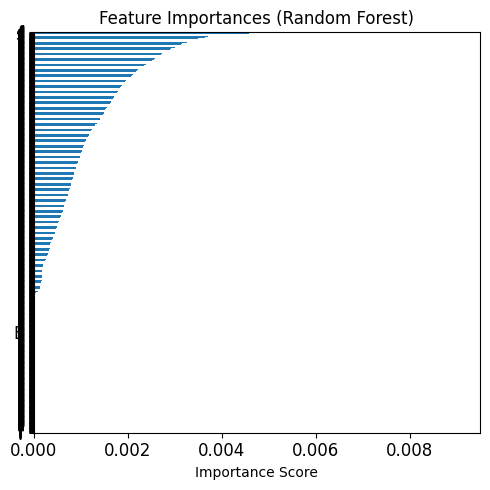

In [65]:
#visualizing feature importance
import matplotlib.pyplot as plt
short_names = [col[:5] for col in importance_df.index]  # or any number of chars
importance_df.index = short_names
plt.figure(figsize=(5, 5))  # Increase figure height and width
importance_df.sort_values().plot(kind='barh', fontsize=12)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

Select ids  while keeping the age/sex group same

In [ ]:

# Just the IDs

sampled_ids = participants['participant_id'].tolist()

num_rows = participants.shape[0]
participants['age_group'] = pd.cut(participants['age.6'], bins=[5.0, 13.0, 18.0], labels=['5-13', '13-18'], right=False)
participants['strata'] = participants['sex.6'] + '_' + participants['age_group'].astype(str)
df_strat = participants.dropna(subset=['strata'])

# Stratified sampling
sampled_df, _ = train_test_split(
    df_strat,
    train_size=238,
    stratify=df_strat['strata'],
    random_state=42
)
